In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

from code.modelhelper import *

In [2]:
N_VOCAB = 4000
N_CLASS = 2
BATCH_SIZE = 512
EPOCHS = 200

In [3]:
x = np.load("data/x_word.npy")
y = np.load("data/y_onehot.npy")

In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42)

In [5]:
print(x.shape, y.shape)

(127284, 24) (127284, 2)


In [6]:
model_input = Input(shape=(x.shape[1], ))
H = Embedding(N_VOCAB, 32)(model_input)
H = SpatialDropout1D(0.25)(H)
H = LSTM(32)(H)
model_output = Dense(N_CLASS, activation="softmax")(H)

model = Model(model_input, model_output)
model.summary()

model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 32)            128000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 24, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 136,386
Trainable params: 136,386
Non-trainable params: 0
_________________________________________________________________


In [7]:
es = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(x_test, y_test),
    callbacks=[es]
)

score = model.evaluate(x_test, y_test, verbose=0)

W0820 20:58:00.034816 4626777536 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 89098 samples, validate on 38186 samples
Epoch 1/200
89098/89098 [==============================] - 8s 86us/sample - loss: 0.2502 - accuracy: 0.9058 - val_loss: 0.0969 - val_accuracy: 0.9667
Epoch 2/200
89098/89098 [==============================] - 6s 73us/sample - loss: 0.0842 - accuracy: 0.9724 - val_loss: 0.0806 - val_accuracy: 0.9730
Epoch 3/200
89098/89098 [==============================] - 6s 71us/sample - loss: 0.0719 - accuracy: 0.9771 - val_loss: 0.0768 - val_accuracy: 0.9749
Epoch 4/200
89098/89098 [==============================] - 6s 71us/sample - loss: 0.0669 - accuracy: 0.9788 - val_loss: 0.0748 - val_accuracy: 0.9759
Epoch 5/200
89098/89098 [==============================] - 6s 71us/sample - loss: 0.0635 - accuracy: 0.9799 - val_loss: 0.0827 - val_accuracy: 0.9739
Epoch 6/200
89098/89098 [==============================] - 6s 72us/sample - loss: 0.0626 - accuracy: 0.9803 - val_loss: 0.0764 - val_accuracy: 0.9755
Epoch 7/200
89098/89098 [=========================

Epoch 55/200
89098/89098 [==============================] - 6s 70us/sample - loss: 0.0444 - accuracy: 0.9862 - val_loss: 0.0980 - val_accuracy: 0.9749
Epoch 56/200
89098/89098 [==============================] - 6s 70us/sample - loss: 0.0443 - accuracy: 0.9862 - val_loss: 0.0982 - val_accuracy: 0.9755
Epoch 57/200
89098/89098 [==============================] - 6s 70us/sample - loss: 0.0444 - accuracy: 0.9861 - val_loss: 0.0985 - val_accuracy: 0.9748
Epoch 58/200
89098/89098 [==============================] - 6s 70us/sample - loss: 0.0437 - accuracy: 0.9862 - val_loss: 0.0985 - val_accuracy: 0.9750
Epoch 59/200
89098/89098 [==============================] - 6s 70us/sample - loss: 0.0440 - accuracy: 0.9862 - val_loss: 0.1010 - val_accuracy: 0.9751
Epoch 60/200
89098/89098 [==============================] - 6s 71us/sample - loss: 0.0440 - accuracy: 0.9863 - val_loss: 0.1014 - val_accuracy: 0.9755
Epoch 61/200
89098/89098 [==============================] - 6s 70us/sample - loss: 0.0442 - ac

89098/89098 [==============================] - 6s 69us/sample - loss: 0.0399 - accuracy: 0.9876 - val_loss: 0.1192 - val_accuracy: 0.9752
Epoch 110/200
89098/89098 [==============================] - 6s 69us/sample - loss: 0.0399 - accuracy: 0.9877 - val_loss: 0.1176 - val_accuracy: 0.9750


In [8]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

y_pred = to_bin(model.predict(x_test))
print("Test recall: {}".format(recall(y_test, y_pred)))

y_test0 = to_1D(y_test)
y_pred0 = to_1D(y_pred)
print(confusion_matrix(y_test0, y_pred0))

Test loss: 0.07477342652028467
Test accuracy: 0.97658825
Test recall: 0.9065519323671497
[[31287   275]
 [  619  6005]]


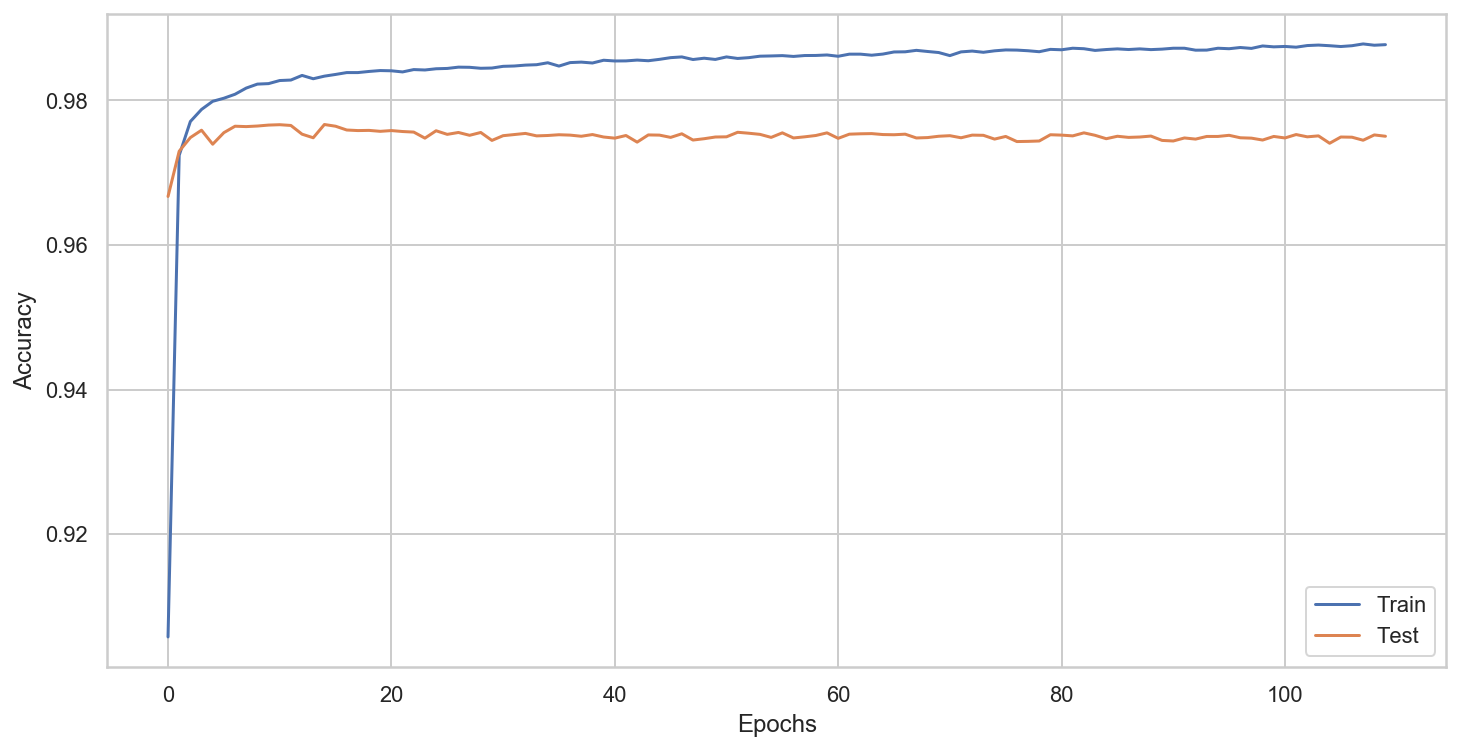

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [10]:
# model.save("models/lstm_word.h5")